In [1]:
import os
import numpy as np
import trimesh
import pyrender
import h5py
from mesh_to_png import mesh_to_png
from landmarks import detect_landmark
from data_def import PCAModel, Mesh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable


In [2]:
face_image = mpimg.imread('leo.jpg')
# face_image = (doge_image[:, :, :3] * 256).astype(np.uint8)

face_landmarks_gt = detect_landmark(face_image)

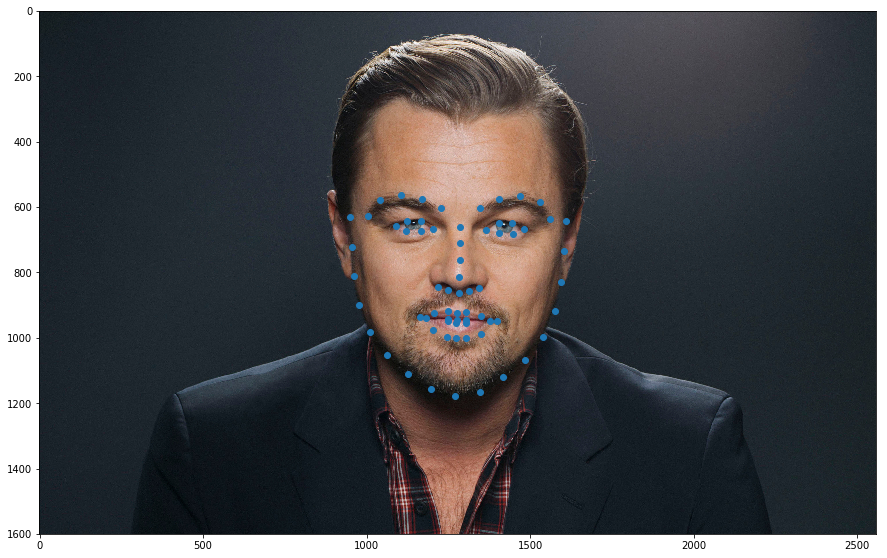

In [3]:
fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/face_landmarks_gt.png')

In [11]:
# Read Basel Face Model.
N_id = 30
N_exp = 20

bfm = h5py.File("model2017-1_face12_nomouth.h5", 'r')
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
# PCA model for facial identity.
mu_id = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_id = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32).reshape((-1, 3, 199))
pcaVariance_id = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
# PCA model for expression.
mu_exp = np.asarray(bfm['expression/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_exp = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32).reshape((-1, 3, 100))
pcaVariance_exp = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)

# Pick the largest N_id and N_exp principal components and variances for facial identity and expressions respectively.
E_id = pcaBasis_id[:, :, :N_id]
E_exp = pcaBasis_exp[:, :, :N_exp]
sigma_id = np.sqrt(pcaVariance_id[:N_id])
sigma_exp = np.sqrt(pcaVariance_exp[:N_exp])

# Convert all to PyTorch tensors.
mu_id_torch = torch.Tensor(mu_id)
mu_exp_torch = torch.Tensor(mu_exp)
E_id_torch = torch.Tensor(E_id)
E_exp_torch = torch.Tensor(E_exp)
sigma_id_torch = torch.Tensor(sigma_id)
sigma_exp_torch = torch.Tensor(sigma_exp)

# Read facial landmark indices.
landmarks=[]
with open('Landmarks68_model2017-1_face12_nomouth.anl','r') as f:
    for line in f.readlines():
        landmarks.append(int(line.split('\n')[0]))
landmarks = torch.tensor(landmarks)
# Define groundtruth facial landmarks.
gt_landmark = torch.Tensor(face_landmarks_gt).t()

# Initialize trainable variables.
lambda_alpha = 1
lambda_delta = 1

alpha = Variable(torch.FloatTensor(N_id).uniform_(-1, 1), requires_grad=True)
delta = Variable(torch.FloatTensor(N_exp).uniform_(-1, 1), requires_grad=True)
omega = Variable(torch.FloatTensor(3).uniform_(-np.pi, np.pi), requires_grad=True)
t = Variable(torch.Tensor([0, 0, -400]), requires_grad=True)

# Initialize optimizer.
opt = torch.optim.Adam([alpha, delta, omega, t], lr=0.1)

# Define camera projection matrices.
vl,vr,vb,vt = -1,1,-1,1
V = torch.Tensor([[(vr-vl)/2.,0,0,(vr+vl)/2.],
              [0,(vt-vb)/2.,0,(vt+vb)/2.],
              [0,0,0.5,0.5],
              [0,0,0,1]])
l,r,b,t_,n,f = -1,1,-1,1,1,100
P = torch.Tensor([[(2*n)/(r-l),0,(r+l)/(r-l),0],
              [0,(2*n)/(t_-b),(t_+b)/(t_-b),0],
              [0,0,-(f+n)/(f-n),-(2*f*n)/(f-b)],
              [0,0,-1,0]])

# G_landmark = torch.ones((4,len(landmarks)))

for epoch in np.arange(500):
    opt.zero_grad()    
    G = mu_id_torch + E_id_torch @ (alpha * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta * sigma_exp_torch)    
    G_landmark_tmp = torch.transpose(torch.index_select(G, 0, landmarks), 0, 1)
    G_landmark = torch.cat((G_landmark_tmp, torch.ones(1, len(landmarks))), 0)
    
    Rx, Ry, Rz = torch.zeros(3, 3), torch.zeros(3, 3), torch.zeros(3, 3)
    Rx[0, 0] = 1.
    Rx[1, 1] = torch.cos(omega[0])
    Rx[1, 2] = -torch.sin(omega[0])
    Rx[2, 1] = torch.sin(omega[0])
    Rx[2, 2] = torch.cos(omega[0])
#     Rx = torch.tensor([[1., 0., 0.], 
#                        [0, torch.cos(omega[0]), -torch.sin(omega[0])], 
#                        [0, torch.sin(omega[0]), torch.cos(omega[0])]
#                       ], requires_grad=True)
    Ry[0, 0] = torch.cos(omega[1])
    Ry[0, 2] = torch.sin(omega[1])
    Ry[1, 1] = 1.
    Ry[2, 0] = -torch.sin(omega[1])
    Ry[2, 2] = torch.cos(omega[1])
#     Ry = torch.tensor([[torch.cos(omega[1]), 0, torch.sin(omega[1])],
#                        [0., 1., 0.],
#                        [-torch.sin(omega[1]), 0, torch.cos(omega[1])]
#                       ], requires_grad=True)
    
    Rz[0, 0] = torch.cos(omega[2])
    Rz[0, 1] = -torch.sin(omega[2])
    Rz[1, 0] = torch.sin(omega[2])
    Rz[1, 1] = torch.cos(omega[2])
    Rz[2, 2] = 1.
#     Rz = torch.tensor([[torch.cos(omega[2]), -torch.sin(omega[2]), 0],
#                        [torch.sin(omega[2]), torch.cos(omega[2]), 0],
#                        [0., 0., 1.]
#                       ], requires_grad=True)
    
    R = Rx @ Ry @ Rz
    T = torch.cat((torch.cat((R, t.view(-1, 1)), dim=1), torch.tensor([0., 0., 0., 1.]).view(1, -1)), dim=0)   

    out = V @ P @ T @ G_landmark
    pred_landmark = torch.empty_like(gt_landmark)
    # Divide by the homogeneous dimension?
#     pred_landmark[0, :] = out[0, :] / out[3, :]
    pred_landmark[0, :] = out[0, :]
#     pred_landmark[1, :] = out[1, :] / out[3, :]
    pred_landmark[1, :] = out[1, :]

    L_landmark = (pred_landmark - gt_landmark).pow(2).sum(dim=0).sqrt().sum()
    L_regularizer = lambda_alpha * alpha.pow(2).sum() + lambda_delta * delta.pow(2).sum()
    L_fit = L_landmark + L_regularizer
    L_fit.backward(retain_graph=True)
    opt.step()    
    print('Epoch: {}, L_landmark: {:.3f}, L_regularizer: {:.3f}'.format(epoch, L_landmark, L_regularizer))



Epoch: 0, L_landmark: 105522.273, L_regularizer: 11.764
Epoch: 1, L_landmark: 104627.219, L_regularizer: 10.543
Epoch: 2, L_landmark: 103723.211, L_regularizer: 10.355
Epoch: 3, L_landmark: 102828.727, L_regularizer: 10.903
Epoch: 4, L_landmark: 101959.773, L_regularizer: 12.092
Epoch: 5, L_landmark: 101133.719, L_regularizer: 13.846
Epoch: 6, L_landmark: 100367.875, L_regularizer: 16.078
Epoch: 7, L_landmark: 99677.523, L_regularizer: 18.687
Epoch: 8, L_landmark: 99074.797, L_regularizer: 21.582
Epoch: 9, L_landmark: 98567.430, L_regularizer: 24.715
Epoch: 10, L_landmark: 98158.172, L_regularizer: 28.084
Epoch: 11, L_landmark: 97844.484, L_regularizer: 31.708
Epoch: 12, L_landmark: 97618.977, L_regularizer: 35.597
Epoch: 13, L_landmark: 97470.141, L_regularizer: 39.745
Epoch: 14, L_landmark: 97383.617, L_regularizer: 44.144
Epoch: 15, L_landmark: 97343.469, L_regularizer: 48.791
Epoch: 16, L_landmark: 97333.680, L_regularizer: 53.688
Epoch: 17, L_landmark: 97339.375, L_regularizer: 58

Epoch: 149, L_landmark: 91423.148, L_regularizer: 1321.829
Epoch: 150, L_landmark: 91390.898, L_regularizer: 1330.971
Epoch: 151, L_landmark: 91358.742, L_regularizer: 1340.104
Epoch: 152, L_landmark: 91326.680, L_regularizer: 1349.227
Epoch: 153, L_landmark: 91294.703, L_regularizer: 1358.341
Epoch: 154, L_landmark: 91262.805, L_regularizer: 1367.445
Epoch: 155, L_landmark: 91230.992, L_regularizer: 1376.538
Epoch: 156, L_landmark: 91199.266, L_regularizer: 1385.621
Epoch: 157, L_landmark: 91167.617, L_regularizer: 1394.693
Epoch: 158, L_landmark: 91136.062, L_regularizer: 1403.754
Epoch: 159, L_landmark: 91104.578, L_regularizer: 1412.803
Epoch: 160, L_landmark: 91073.195, L_regularizer: 1421.841
Epoch: 161, L_landmark: 91041.875, L_regularizer: 1430.868
Epoch: 162, L_landmark: 91010.648, L_regularizer: 1439.882
Epoch: 163, L_landmark: 90979.508, L_regularizer: 1448.884
Epoch: 164, L_landmark: 90948.438, L_regularizer: 1457.874
Epoch: 165, L_landmark: 90917.445, L_regularizer: 1466.8

Epoch: 292, L_landmark: 87501.281, L_regularizer: 2501.762
Epoch: 293, L_landmark: 87477.547, L_regularizer: 2509.258
Epoch: 294, L_landmark: 87453.844, L_regularizer: 2516.748
Epoch: 295, L_landmark: 87430.188, L_regularizer: 2524.230
Epoch: 296, L_landmark: 87406.570, L_regularizer: 2531.706
Epoch: 297, L_landmark: 87382.977, L_regularizer: 2539.175
Epoch: 298, L_landmark: 87359.453, L_regularizer: 2546.635
Epoch: 299, L_landmark: 87335.922, L_regularizer: 2554.090
Epoch: 300, L_landmark: 87312.453, L_regularizer: 2561.537
Epoch: 301, L_landmark: 87289.023, L_regularizer: 2568.978
Epoch: 302, L_landmark: 87265.633, L_regularizer: 2576.411
Epoch: 303, L_landmark: 87242.266, L_regularizer: 2583.839
Epoch: 304, L_landmark: 87218.930, L_regularizer: 2591.259
Epoch: 305, L_landmark: 87195.648, L_regularizer: 2598.673
Epoch: 306, L_landmark: 87172.398, L_regularizer: 2606.080
Epoch: 307, L_landmark: 87149.180, L_regularizer: 2613.481
Epoch: 308, L_landmark: 87126.000, L_regularizer: 2620.8

Epoch: 431, L_landmark: 84509.891, L_regularizer: 3485.146
Epoch: 432, L_landmark: 84490.297, L_regularizer: 3491.792
Epoch: 433, L_landmark: 84470.750, L_regularizer: 3498.432
Epoch: 434, L_landmark: 84451.188, L_regularizer: 3505.064
Epoch: 435, L_landmark: 84431.680, L_regularizer: 3511.691
Epoch: 436, L_landmark: 84412.195, L_regularizer: 3518.309
Epoch: 437, L_landmark: 84392.727, L_regularizer: 3524.921
Epoch: 438, L_landmark: 84373.281, L_regularizer: 3531.526
Epoch: 439, L_landmark: 84353.859, L_regularizer: 3538.124
Epoch: 440, L_landmark: 84334.461, L_regularizer: 3544.714
Epoch: 441, L_landmark: 84315.102, L_regularizer: 3551.298
Epoch: 442, L_landmark: 84295.758, L_regularizer: 3557.875
Epoch: 443, L_landmark: 84276.438, L_regularizer: 3564.443
Epoch: 444, L_landmark: 84257.125, L_regularizer: 3571.006
Epoch: 445, L_landmark: 84237.844, L_regularizer: 3577.561
Epoch: 446, L_landmark: 84218.602, L_regularizer: 3584.108
Epoch: 447, L_landmark: 84199.375, L_regularizer: 3590.6

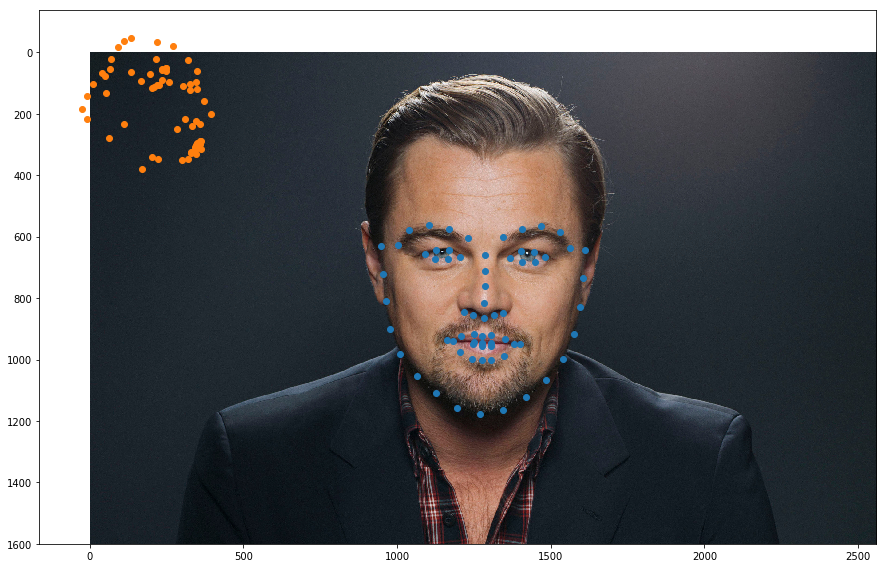

In [12]:
fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.scatter(pred_landmark.detach().numpy()[0, :], pred_landmark.detach().numpy()[1, :])
plt.axes().set_aspect('equal')
plt.show()

In [ ]:
from torchviz import make_dot
graph = make_dot(L_landmark)
graph.view()